In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importe datasets

# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Modèles pré-entrainés
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2023-12-22 16:44:50--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.13.207, 172.217.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  68.8MB/s    in 7.1s    

2023-12-22 16:44:57 (111 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2023-12-22 16:44:57--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.13.207, 172.217.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125947904

**Combinaison des datasets**

In [3]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

In [4]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [5]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

In [6]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [7]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


Sample cat image:


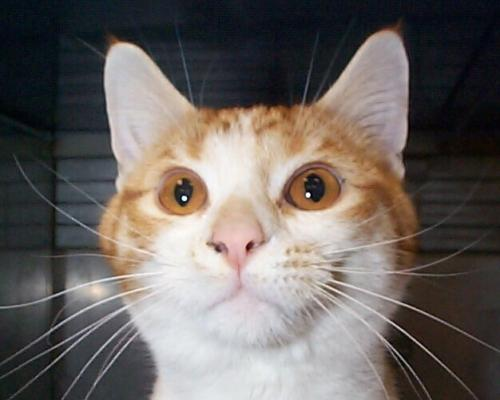


Sample dog image:


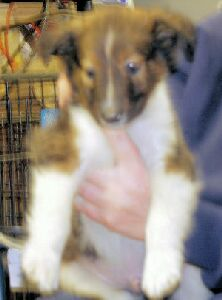


Sample bird image:


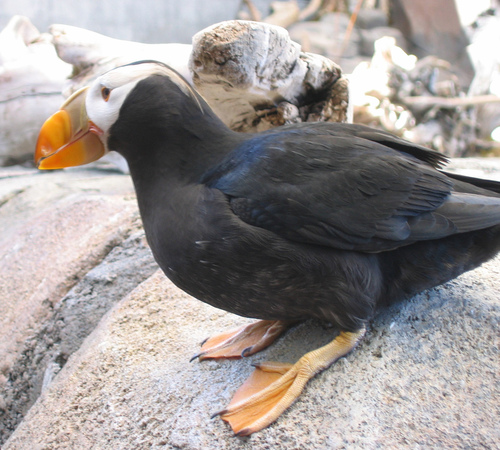

In [8]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

**Train/Test**

In [9]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [10]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

In [11]:
# 70% images train
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# 30 % images test
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

**Résolution conflits mauvaises images**

In [12]:
!find /tmp/data/ -size 0 -exec rm {} +
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

In [13]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


In [17]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # CNN
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compilation du model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [19]:
balanced_model = create_model()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [25]:
balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [26]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [30]:
y_true = val_gen_no_shuffle.classes

# Prédiction
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)


y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print l'accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print le balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

345/345 [==============================] - 168s 485ms/step
Accuracy Score: 0.8646248640811889
Balanced Accuracy Score: 0.8656947233653035


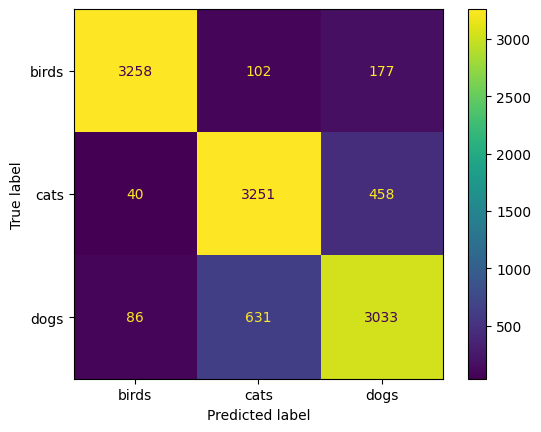

In [31]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

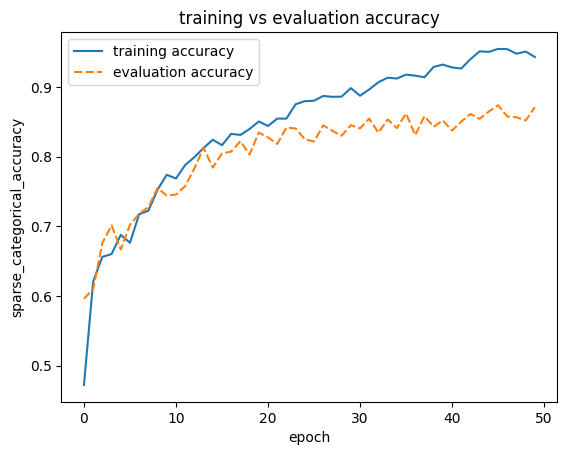

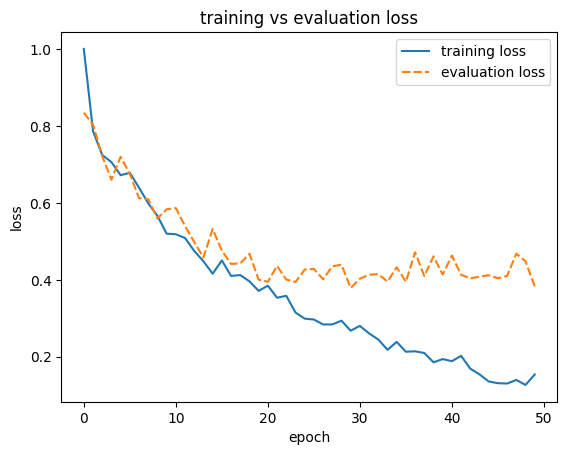

In [32]:
plot_train_eval(balanced_history)

**Avec Data Augmentation**

In [34]:
augmented_model = create_model()

In [35]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.



Transformation number: 0



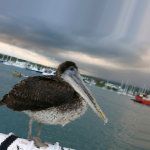


Transformation number: 1



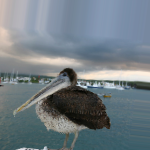


Transformation number: 2



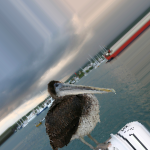


Transformation number: 3



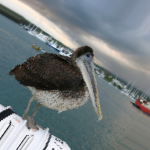

In [36]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img



def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)



sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)


Transformation number: 0



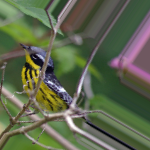


Transformation number: 1



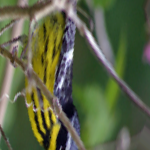


Transformation number: 2



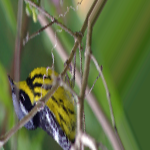


Transformation number: 3



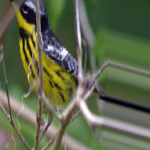

In [37]:
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [ ]:
# Modèle augmenté pré-entrainé

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

In [ ]:
# augmented_history = augmented_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=80,
#     validation_data=validation_generator,
#     validation_steps=80)

In [ ]:
plot_train_eval(augmented_history)